In [1]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, StandardScaler

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5722792/

The frontal asymmetry is most commonly computed by subtracting the natural log of left hemisphere alpha power (EEG electrode F3) from the natural log of right hemisphere alpha power (F4) while using the central Cz as reference electrode

In [2]:
participants = []
pd_raws = []
files = glob(f"data/*.csv")
for index, f in enumerate(files):
    name = f.split('/')[1].split('__')[0]
    participants.append(name)
    pd_raw = pd.read_csv(f, dtype={'Marker':str})
    pd_raw = pd_raw.drop(columns='timestamps')
    # print(pd_raw.Marker.unique())
    # pd_raw = marker_converter(pd_raw,marker_names)
    print(f"{index} {name} | time: {len(pd_raw)/125}")
    pd_raws.append(pd_raw)
# print(participants)


0 beau | time: 612.768
1 nuclear | time: 611.04
2 minkhant | time: 609.312
3 new | time: 609.504
4 sam | time: 609.792
5 fabby | time: 606.816
6 nopphon | time: 615.744
7 prin | time: 610.752
8 film | time: 606.912
9 yong | time: 611.52
10 MJ | time: 476.544
11 nice | time: 611.136
12 dt | time: 611.424
13 am | time: 612.288
14 flm | time: 602.688
15 bas | time: 608.832
16 int | time: 611.04
17 taew | time: 641.952
18 pang | time: 609.504
19 boss | time: 617.76
20 mind | time: 613.056


In [3]:
raws = []
sampling_rate = 125 # Hz
with tqdm(pd_raws) as pbar:
    for index,pd_raw in enumerate(pbar):
        pbar.set_description(f"{index} {participants[index]}")
        raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
        raws.append(raw)

  0%|          | 0/21 [00:00<?, ?it/s]

0 beau


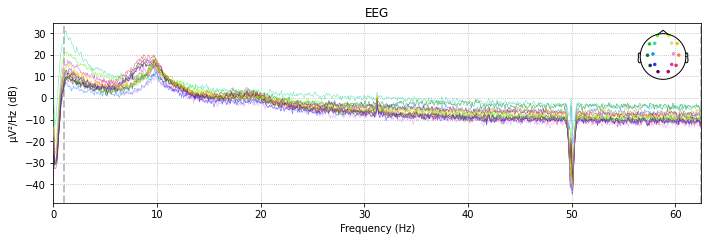

1 nuclear


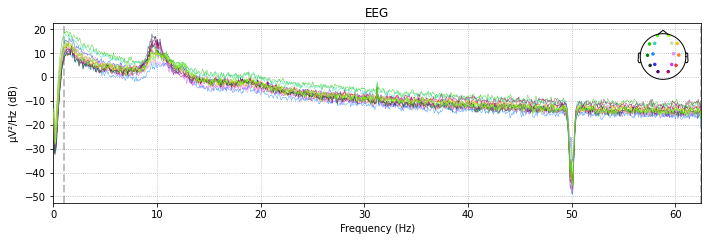

2 minkhant


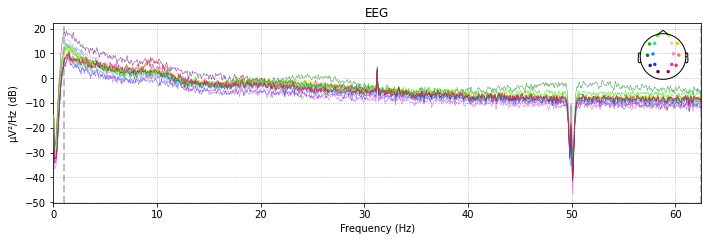

3 new


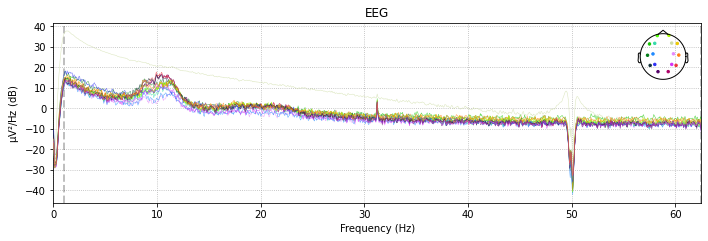

4 sam


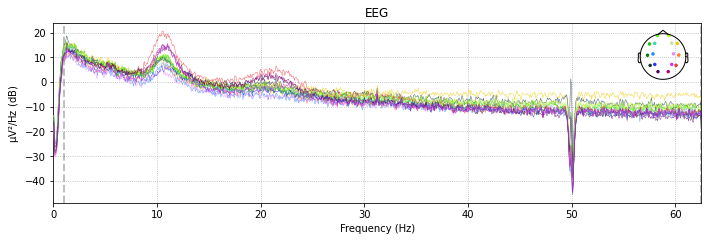

5 fabby


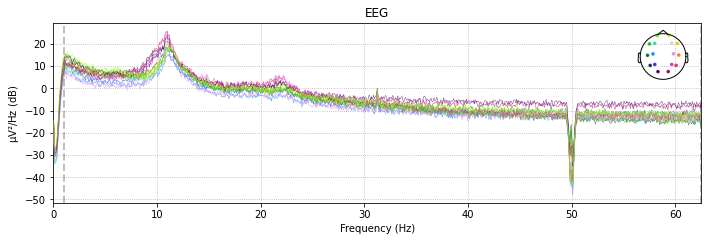

6 nopphon


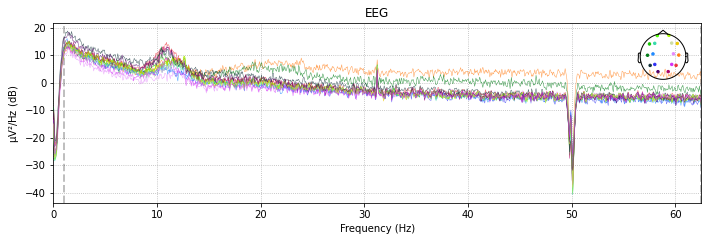

7 prin


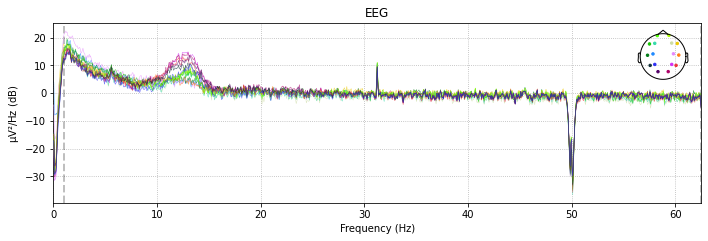

8 film


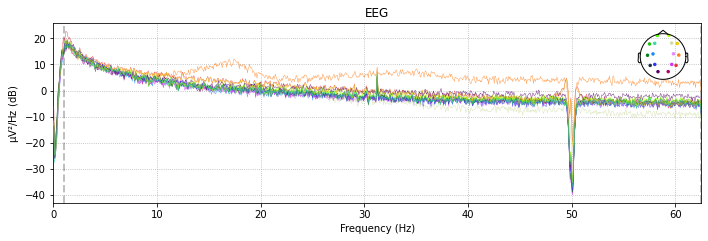

9 yong


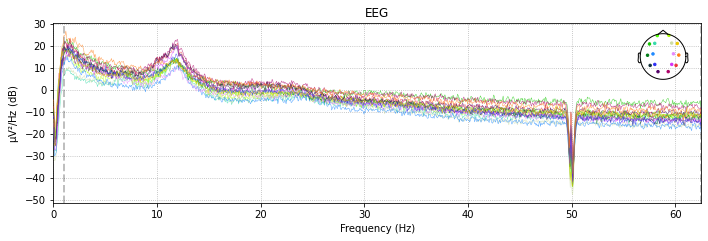

10 MJ


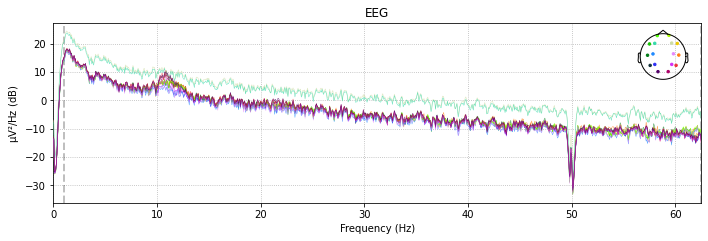

11 nice


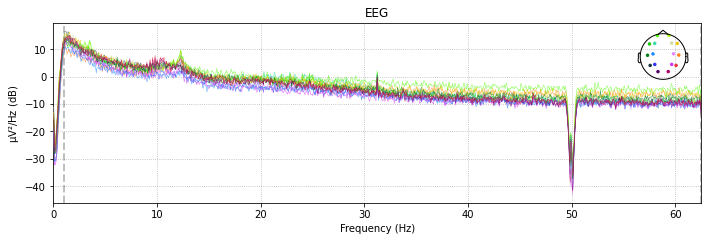

12 dt


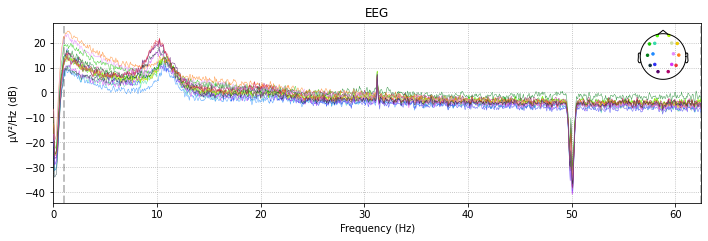

13 am


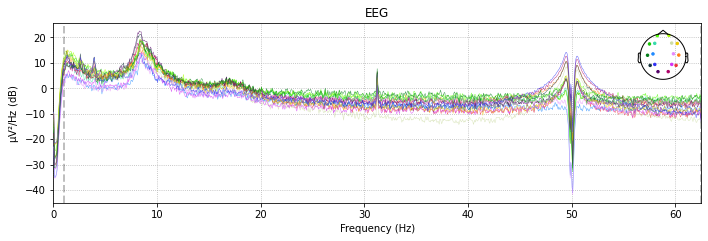

14 flm


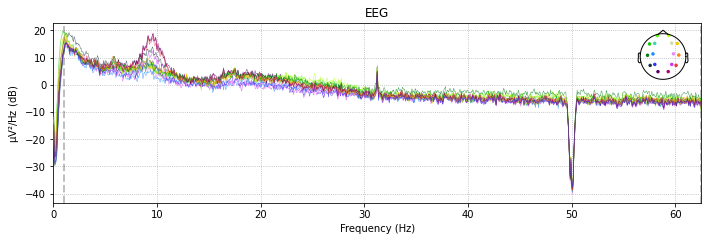

15 bas


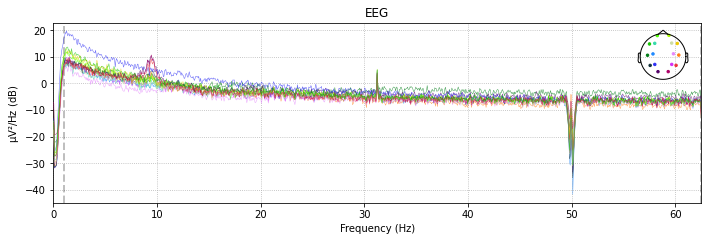

16 int


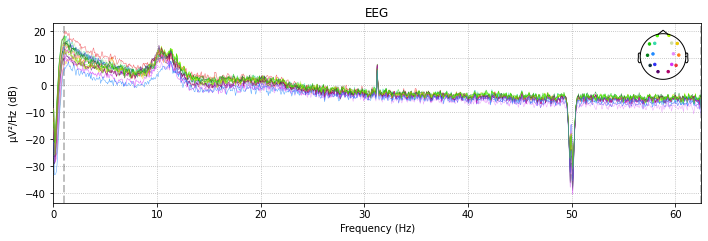

17 taew


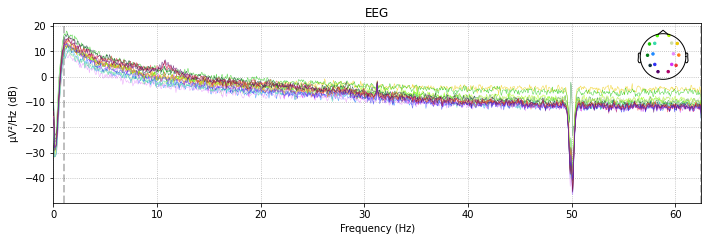

18 pang


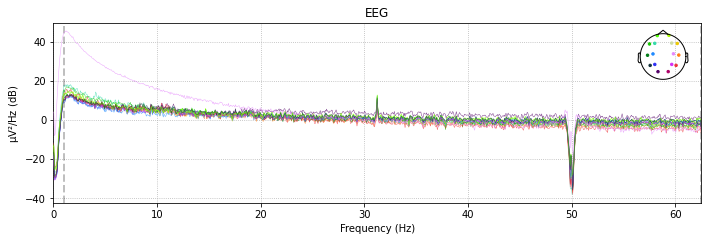

19 boss


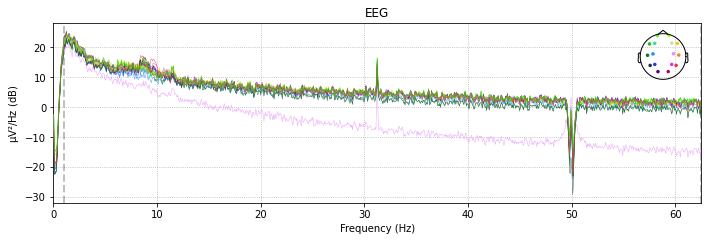

20 mind


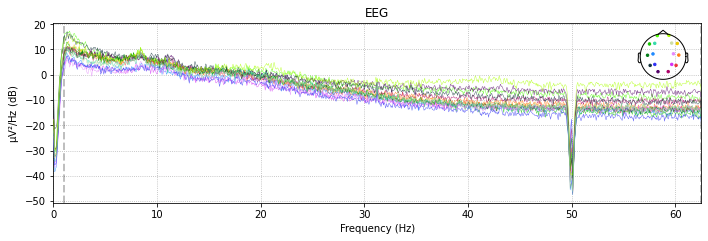

In [4]:
for index,raw in enumerate(raws):
    print(index, participants[index])
    raw.filter(l_freq=1,h_freq=None, method='iir', iir_params={'order':3.0, 'ftype':'butter'}, verbose=False) # Slow drift
    raw.notch_filter(freqs=[50])
    raw.plot_psd()

In [5]:
raw = raws[participants.index('MJ')]
power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=True)

Effective window size : 1.000 (s)


In [6]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta'])
filter_list = [[1,3],[4,7],[8,12],[13,30],[30,43], [4,13], [13,17]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)
print(bands)

[array([1, 2, 3]) array([4, 5, 6, 7]) array([ 8,  9, 10, 11, 12])
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30])
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
 array([13, 14, 15, 16, 17])]


<ipython-input-6-3759ae126e95>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [7]:
features = None
for raw in raws:
    feature = None
    slow, gamma = None, None
    a_f3, a_f4 = None, None
    a_t7, a_t8 = None, None
    b_f3, b_f4 = None, None
    b_t7, b_t8 = None, None
    for index, band in enumerate(bands):
        power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=False)
        power = 10 * np.log10(power)
        data = power[::,band].mean(axis=1).reshape(1,-1)
        # for asym
        if(band_names[index] == 'Alpha'):
            a_f3 = data[:,raw.ch_names.index('F3')]
            a_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            a_t7 = data[:,raw.ch_names.index('T3')]
            a_t8 = data[:,raw.ch_names.index('T4')]
        if(band_names[index] == 'Beta'):
            b_f3 = data[:,raw.ch_names.index('F3')]
            b_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            b_t7 = data[:,raw.ch_names.index('T3')]
            b_t8 = data[:,raw.ch_names.index('T4')]

        ####### Mean for visualization #######
        data = data.mean().reshape(1,-1)
        # for relative gamma
        if(band_names[index] == 'Slow'): slow = data
        if(band_names[index] == 'Gamma'): gamma = data

        if(type(feature) == type(None)): feature = data
        else: feature = np.concatenate([feature, data], axis=1)
    # print(feature.shape)
    # the eighth feature: relative gamma is slow/gamma
    relative_gamma = slow/gamma
    feature = np.concatenate([feature, relative_gamma], axis=1)
    # The asymetry
    alpha_frontal = ((a_f4 - a_f3) / (a_f4 + a_f3)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_frontal], axis=1)
    # alpha_temporal
    alpha_temporal = ((a_t8 - a_t7) / (a_t8 + a_t7)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_temporal], axis=1)
    # alpha_asymmetry
    alpha_asymmetry = alpha_frontal + alpha_temporal
    feature = np.concatenate([feature, alpha_asymmetry], axis=1)
    # beta_frontal
    beta_frontal = ((b_f4 - b_f3) / (b_f4 + b_f3)).reshape(1,-1)
    feature = np.concatenate([feature, beta_frontal], axis=1)
    # beta_temporal
    beta_temporal = ((b_t8 - b_t7) / (b_t8 + b_t7)).reshape(1,-1)
    feature = np.concatenate([feature, beta_temporal], axis=1)

    # print(slow/gamma)
    # print(feature.shape)
    # print(feature)
    if(type(features) == type(None)): features = feature
    else: features = np.concatenate([features, feature], axis=0)
print(features.shape)


(21, 13)


In [8]:
print(features)

[[-1.09923346e+02 -1.13766586e+02 -1.10031468e+02 -1.21644276e+02
  -1.26560684e+02 -1.12199890e+02 -1.18620460e+02  8.86530371e-01
  -3.13349187e-03  3.22222985e-03  8.87379780e-05  1.98907467e-02
   7.35461087e-03]
 [-1.10119290e+02 -1.15398821e+02 -1.13458457e+02 -1.24564322e+02
  -1.30640528e+02 -1.14713415e+02 -1.20972985e+02  8.78084439e-01
   6.88050299e-03  3.04230444e-03  9.92280744e-03  1.01270477e-02
   1.37663929e-03]
 [-1.11754696e+02 -1.15867894e+02 -1.18506766e+02 -1.23342194e+02
  -1.26423310e+02 -1.17752962e+02 -1.22427749e+02  9.31418124e-01
  -5.47410777e-03 -1.62442155e-03 -7.09852932e-03 -5.39856322e-03
   9.65337688e-03]
 [-1.07202827e+02 -1.12406989e+02 -1.10025107e+02 -1.20194302e+02
  -1.24826193e+02 -1.11533489e+02 -1.18101176e+02  8.93510300e-01
  -6.25077178e-02  1.75678331e-03 -6.07509345e-02 -5.75892754e-02
   9.42698779e-04]
 [-1.09344661e+02 -1.14462257e+02 -1.13806408e+02 -1.23298081e+02
  -1.28582842e+02 -1.14465079e+02 -1.20830631e+02  8.90204925e-01


In [9]:
def NormJa(data):
    for index, row in enumerate(data):
        min = row.min()
        max = row.max()
        mean = row.mean()
        row = (row - min) / (max - min)
        data[index] = row
        # print(row)
    return data
# NormJa(features.copy())

In [10]:
# Normalize
f_norm = normalize(features.copy(), axis=0)
# f_norm = NormJa(features.copy().T).T
# f_n
print(f_norm)

[[-2.20702114e-01 -2.18774736e-01 -2.11199796e-01 -2.19295872e-01
  -2.20672997e-01 -2.14953161e-01 -2.17930178e-01  2.12361353e-01
  -4.86879800e-02  1.47770618e-01  1.29885528e-03  3.08794271e-01
   1.79005645e-01]
 [-2.21095526e-01 -2.21913546e-01 -2.17777726e-01 -2.24560024e-01
  -2.27786671e-01 -2.19768585e-01 -2.22252250e-01  2.10338196e-01
   1.06908780e-01  1.39519286e-01  1.45239852e-01  1.57217543e-01
   3.35063551e-02]
 [-2.24379066e-01 -2.22815581e-01 -2.27467699e-01 -2.22356816e-01
  -2.20433470e-01 -2.25591766e-01 -2.24924951e-01  2.23113859e-01
  -8.50563079e-02 -7.44955475e-02 -1.03900973e-01 -8.38100962e-02
   2.34955864e-01]
 [-2.15239905e-01 -2.16160212e-01 -2.11187586e-01 -2.16681911e-01
  -2.17648714e-01 -2.13676465e-01 -2.16976147e-01  2.14033339e-01
  -9.71240595e-01  8.05656234e-02 -8.89209713e-01 -8.94045788e-01
   2.29445725e-02]
 [-2.19540240e-01 -2.20112521e-01 -2.18445601e-01 -2.22277291e-01
  -2.24198860e-01 -2.19292822e-01 -2.21990718e-01  2.13241563e-01


In [11]:
print(participants)

['beau', 'nuclear', 'minkhant', 'new', 'sam', 'fabby', 'nopphon', 'prin', 'film', 'yong', 'MJ', 'nice', 'dt', 'am', 'flm', 'bas', 'int', 'taew', 'pang', 'boss', 'mind']


In [12]:
scores = {
    "fabby": 25,
    "bas": 25,
    "flm": 37,
    "mind": 22,
    "taew": 21,
    "MJ": 12,
    "nopphon":22,
    "boss":22,
    "film":18,
    "new":28,
    "nice":18,
    "nuclear":15,
    "pang":29,
    "prin":9,
    "am":13,
    "beau":9,
    "dt":16,
    "int":15,
    "minkhant":24,
    "sam":18,
    "yong":27
}

In [22]:
sum(np.array(list(scores.values()))<20)

10

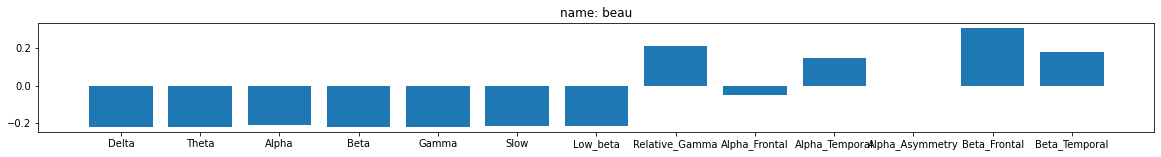

Name: beau, PSS Score:9, Label:Non Stree, Festure:[-0.21929587188791083, 0.0012988552797142585]


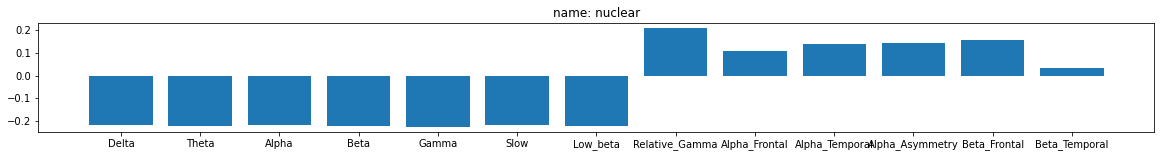

Name: nuclear, PSS Score:15, Label:Non Stree, Festure:[-0.22456002361312213, 0.1452398524368275]


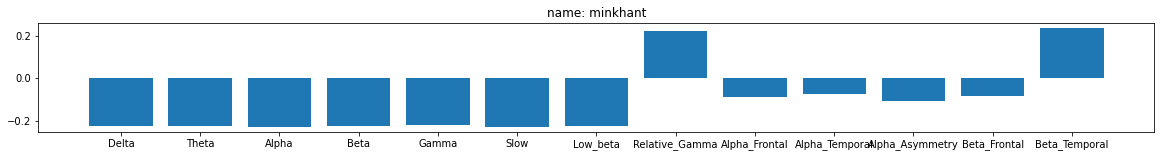

Name: minkhant, PSS Score:24, Label:Stree, Festure:[-0.22235681597817558, -0.1039009733841553]


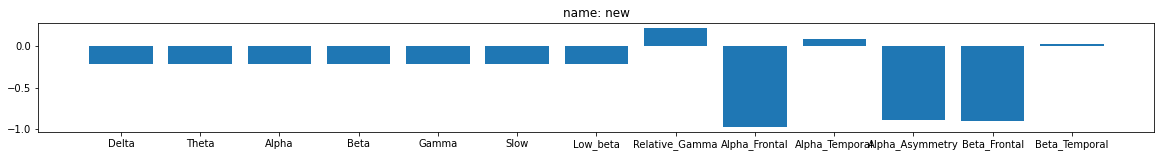

Name: new, PSS Score:28, Label:Stree, Festure:[-0.21668191092419536, -0.8892097132430642]


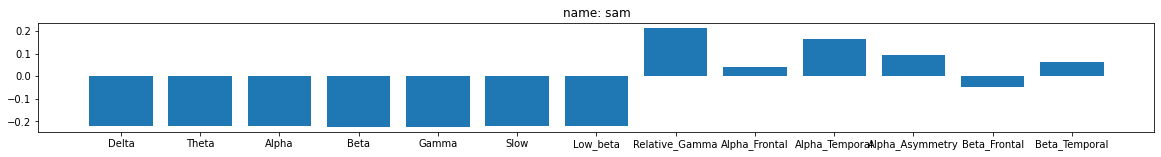

Name: sam, PSS Score:18, Label:Non Stree, Festure:[-0.2222772912016475, 0.09217847198998515]


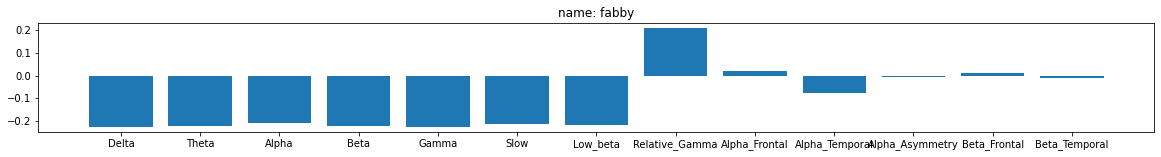

Name: fabby, PSS Score:25, Label:Stree, Festure:[-0.2190014812305742, -0.008014916810409643]


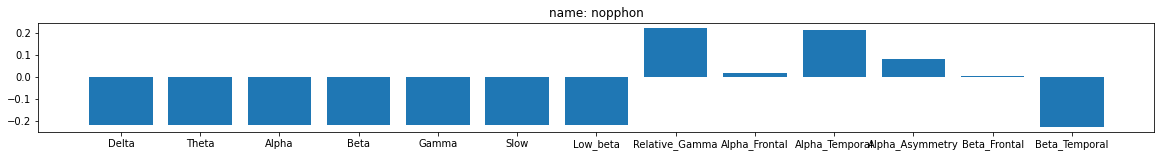

Name: nopphon, PSS Score:22, Label:Stree, Festure:[-0.21651839256475927, 0.08362327192226292]


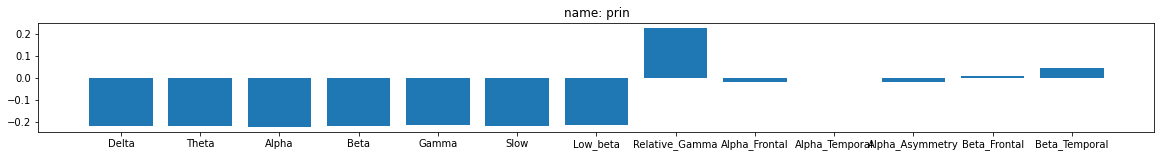

Name: prin, PSS Score:9, Label:Non Stree, Festure:[-0.21443839585208196, -0.015828473990646436]


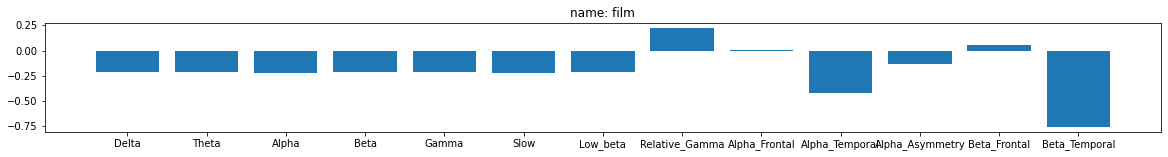

Name: film, PSS Score:18, Label:Non Stree, Festure:[-0.215548240671008, -0.13044982324559548]


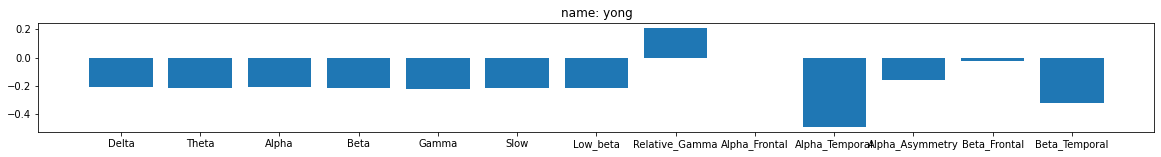

Name: yong, PSS Score:27, Label:Stree, Festure:[-0.21772288784613392, -0.1622177208290476]


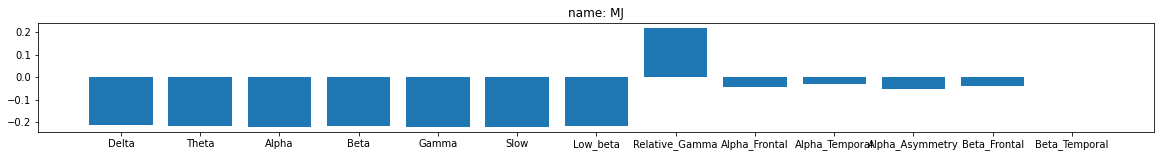

Name: MJ, PSS Score:12, Label:Non Stree, Festure:[-0.21721271982604035, -0.05073277077196583]


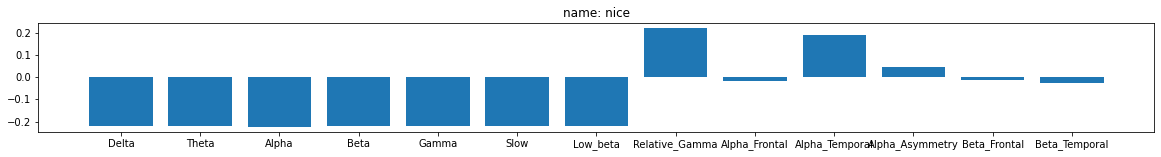

Name: nice, PSS Score:18, Label:Non Stree, Festure:[-0.22029065529080064, 0.043353731300057166]


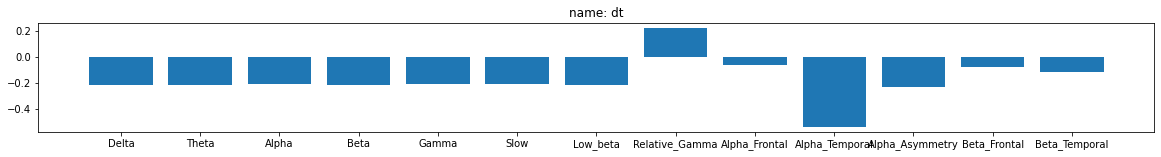

Name: dt, PSS Score:16, Label:Non Stree, Festure:[-0.21689366942703342, -0.23468852671842239]


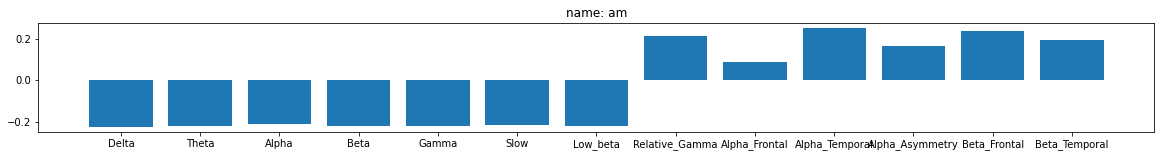

Name: am, PSS Score:13, Label:Non Stree, Festure:[-0.22121199357416377, 0.16577936355184]


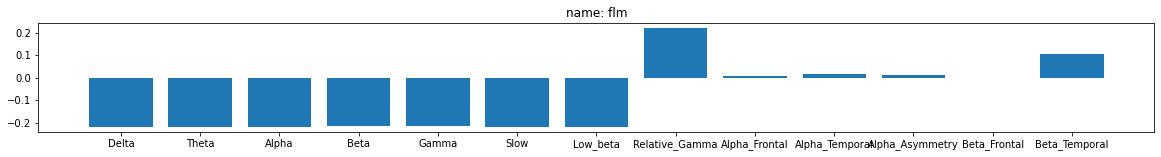

Name: flm, PSS Score:37, Label:Stree, Festure:[-0.2152123873853992, 0.011125346925340346]


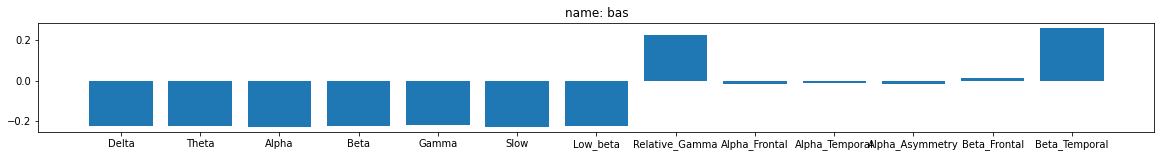

Name: bas, PSS Score:25, Label:Stree, Festure:[-0.22264902459614833, -0.016825873275368313]


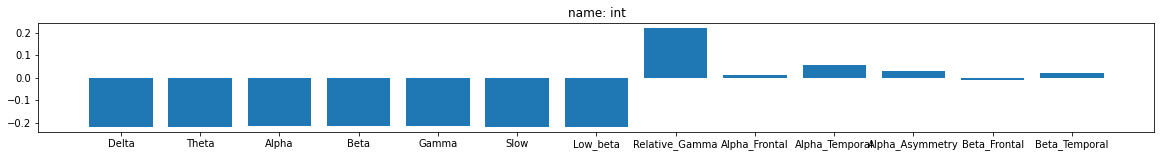

Name: int, PSS Score:15, Label:Non Stree, Festure:[-0.2164679407697544, 0.028995556177340884]


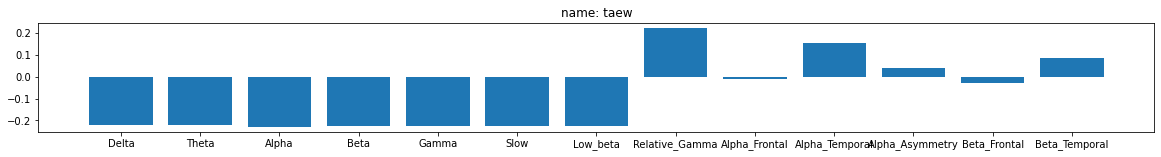

Name: taew, PSS Score:21, Label:Stree, Festure:[-0.22414869163200804, 0.038476135155944835]


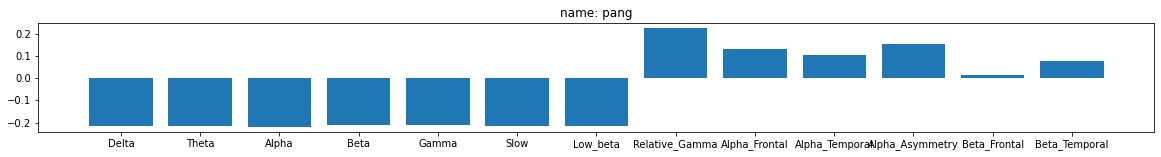

Name: pang, PSS Score:29, Label:Stree, Festure:[-0.21256773016138172, 0.1575323372503847]


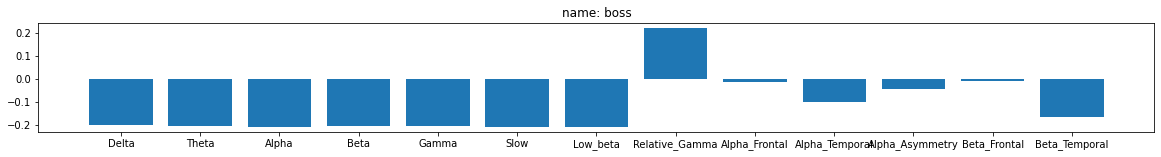

Name: boss, PSS Score:22, Label:Stree, Festure:[-0.20620941657768052, -0.04271384984674773]


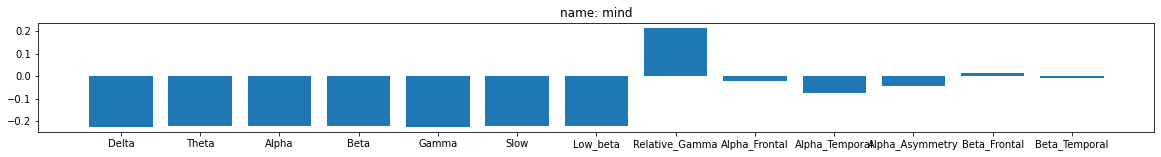

Name: mind, PSS Score:22, Label:Stree, Festure:[-0.2204700714708977, -0.043523716089826525]


In [23]:
# plt.plot(feature)
feature_names = list(band_names)
feature_names.append('Relative_Gamma')
feature_names.append('Alpha_Frontal')
feature_names.append('Alpha_Temporal')
feature_names.append('Alpha_Asymmetry')
feature_names.append('Beta_Frontal')
feature_names.append('Beta_Temporal')
feature_names = np.array(feature_names)
feature_names[[3,10]]
X,y = [], []
for index,participant in enumerate(participants):
    fig,ax = plt.subplots(figsize=(20,2))
    # ax.bar(feature_names[[3,10]],list(f_norm[index,:][[3,10]].reshape(-1)), capsize=10)
    ax.bar(feature_names,list(f_norm[index,:].reshape(-1)), capsize=10)
    ax.set_title(f"name: {participant}")
    plt.show()
    label,cat = 'Stree',0
    if(scores[participant] < 20):
        label,cat = 'Non Stree',1
    X.append(list(f_norm[index,:].reshape(-1)))
    y.append(cat)
    print(f"Name: {participant}, PSS Score:{scores[participant]}, Label:{label}, Festure:{list(f_norm[index,:][[3,10]].reshape(-1))}")
    print("============================================================")

In [27]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

# X = np.array(X)
X = normalize(features.copy(), axis=0)
# X = NormJa(features.copy())
y = np.array(y)
print(X.shape, y.shape)

(21, 13) (21,)


In [28]:
feature_names

array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta',
       'Relative_Gamma', 'Alpha_Frontal', 'Alpha_Temporal',
       'Alpha_Asymmetry', 'Beta_Frontal', 'Beta_Temporal'], dtype='<U15')

In [30]:
mnb = GaussianNB()
mnb.fit(X, y)
ans = mnb.predict(X)
acc = sum(ans == y) / len(y)
cross = cross_val_score(mnb, X, y)
print(acc, cross)
for index,(i,j) in enumerate(zip(ans,y)):
    print(f"pred={i}|Label={j}|Score={scores[participants[index]]}|Name={participants[index]}")

0.7619047619047619 [0.6  0.25 0.5  0.5  0.5 ]
pred=1|Label=1|Score=9|Name=beau
pred=1|Label=1|Score=15|Name=nuclear
pred=0|Label=0|Score=24|Name=minkhant
pred=0|Label=0|Score=28|Name=new
pred=1|Label=1|Score=18|Name=sam
pred=1|Label=0|Score=25|Name=fabby
pred=1|Label=0|Score=22|Name=nopphon
pred=1|Label=1|Score=9|Name=prin
pred=1|Label=1|Score=18|Name=film
pred=1|Label=0|Score=27|Name=yong
pred=1|Label=1|Score=12|Name=MJ
pred=1|Label=1|Score=18|Name=nice
pred=1|Label=1|Score=16|Name=dt
pred=1|Label=1|Score=13|Name=am
pred=1|Label=0|Score=37|Name=flm
pred=0|Label=0|Score=25|Name=bas
pred=1|Label=1|Score=15|Name=int
pred=0|Label=0|Score=21|Name=taew
pred=0|Label=0|Score=29|Name=pang
pred=0|Label=0|Score=22|Name=boss
pred=1|Label=0|Score=22|Name=mind
